# Public Space Quality (PSQ) Index to cluster polygons

This notebooks transfers the PSQ index __data available by street to cluster polygons__ by considering the lenght of each clipped street inside each hex as weight.

(New areas of interes were created on __Oct-Nov 2024__, during the __final adjustment stage of the project__, using K-means.)

## Load libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [3]:
# Projection crs used if needed
projected_crs = "EPSG:32719"

# Save result locally?
save_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/"
save = True

## Load data

__Load calidad ep (Espacio público) data (streets)__

In [4]:
calidad_ep_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/"
calidad_ep = gpd.read_file(calidad_ep_dir + "00_redvial2019_buffer_3750m_c_utilidad_2/original_file/redvial2019_buffer_3750m_c_utilidad_2.shp")
calidad_ep = calidad_ep.set_crs(projected_crs)
calidad_ep = calidad_ep.to_crs("EPSG:4326")

# Show
print(calidad_ep.crs)
print(calidad_ep.shape)
calidad_ep.head(2)

EPSG:4326
(31534, 36)


,IDcllbf,shp_lng,st_lng_,Nom_Rut,Rol_Mop,Clas_Rt,Tip_Crp,Catego,Cod_Rgn,id,...,nr_trtr,ndvi_mn,ndvi_md,es_cll_,utilidd,rank_tl,pje_ep,UV,buffer800,geometry
0,1.0,0.000000,1813.857525,Túnel Kennedy,None,5,None,Urbano,13,1.0,...,0.0,0.121441,0.136500,1.0,0.184971,6596.0,0.209171,0,0,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,2.0,500.073885,33.924649,Av.Dag Hammarskjöld,None,3,None,Urbano,13,1.0,...,0.0,0.162665,0.171817,1.0,0.245950,8637.0,0.273895,0,0,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


__Load cluster polygons__

In [5]:
analysis_polys_dir = "../../../data/external/temporal_todocker/santiago/aois/"
analysis_polys = gpd.read_file(analysis_polys_dir+'Zonas Analisis.geojson')

# Set CRS
try:
    analysis_polys = analysis_polys.set_crs("EPSG:4326")
except:
    analysis_polys = analysis_polys.to_crs("EPSG:4326")

# aois format
analysis_polys['poly_id'] = analysis_polys['cluster']
analysis_polys = analysis_polys[['poly_id','geometry']]

# Show
print(analysis_polys.shape)
analysis_polys.head(2)

(8, 2)


,poly_id,geometry
0,6,"MULTIPOLYGON (((-70.65254 -33.44978, -70.65254..."
1,8,"MULTIPOLYGON (((-70.63163 -33.44983, -70.63163..."


<Axes: >

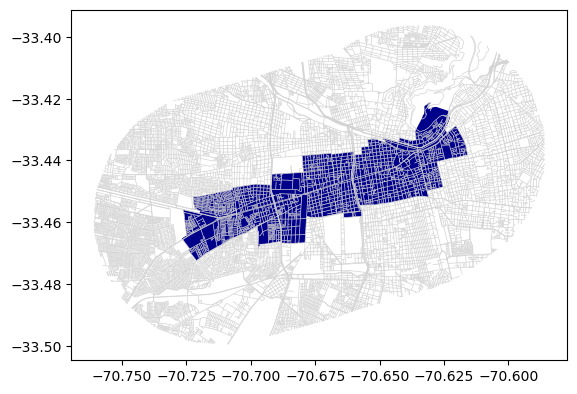

In [6]:
fig,ax = plt.subplots()

calidad_ep.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
analysis_polys.plot(ax=ax,zorder=0,color='darkblue')

## Intersect calidad ep data using polys

In [7]:
intersected_calidad_ep_polys = gpd.overlay(calidad_ep, analysis_polys, how='intersection')
# Show
print(intersected_calidad_ep_polys.crs)
print(intersected_calidad_ep_polys.shape)
intersected_calidad_ep_polys.head(2)

EPSG:4326
(5169, 37)


,IDcllbf,shp_lng,st_lng_,Nom_Rut,Rol_Mop,Clas_Rt,Tip_Crp,Catego,Cod_Rgn,id,...,ndvi_mn,ndvi_md,es_cll_,utilidd,rank_tl,pje_ep,UV,buffer800,poly_id,geometry
0,38.0,137.642140,28.769322,O'Higgins,None,9,None,Urbano,13,1.0,...,0.167830,0.167639,1.0,0.322843,11447.0,0.363005,0,1,4,"LINESTRING (-70.68358 -33.45231, -70.68361 -33..."
1,135.0,44.762601,44.762601,Hermanos Eyraud,None,3,None,Urbano,13,1.0,...,0.051245,0.047090,1.0,-0.526487,315.0,0.009989,0,1,4,"LINESTRING (-70.69343 -33.46001, -70.69343 -33..."


<Axes: >

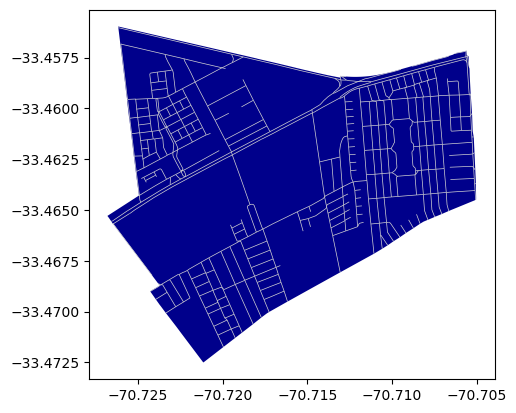

In [8]:
# Intersected result visualization
fig,ax = plt.subplots()
intersected_calidad_ep_polys.loc[intersected_calidad_ep_polys.poly_id==1].plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
analysis_polys.loc[analysis_polys.poly_id==1].plot(ax=ax,zorder=0,color='darkblue')

## Calculate average pje_ep by poly

In [10]:
poly_gdf = analysis_polys.copy()

# Calculate intersected lines length
intersected_calidad_ep_polys = intersected_calidad_ep_polys.to_crs(projected_crs)
intersected_calidad_ep_polys['length'] = intersected_calidad_ep_polys.length
intersected_calidad_ep_polys = intersected_calidad_ep_polys.to_crs("EPSG:4326")

# Calculate weighted average
for poly_id in list(intersected_calidad_ep_polys.poly_id.unique()):

    # Find value for poly's streets
    streets_in_poly = intersected_calidad_ep_polys.loc[intersected_calidad_ep_polys.poly_id == poly_id].copy()
    weighted_avg = aup.weighted_average(streets_in_poly,'length','pje_ep')

    # Register value
    idx = poly_gdf.poly_id == poly_id
    poly_gdf.loc[idx,'pje_ep'] = weighted_avg

# Show
print(poly_gdf.crs)
print(poly_gdf.shape)
poly_gdf.head(2)

EPSG:4326
(8, 3)


,poly_id,geometry,pje_ep
0,6,"MULTIPOLYGON (((-70.65254 -33.44978, -70.65254...",0.639023
1,8,"MULTIPOLYGON (((-70.63163 -33.44983, -70.63163...",0.671787


## Save

In [11]:
if save:
    poly_gdf.rename(columns={'name':'cluster'},inplace=True)
    poly_gdf.to_file(save_dir + f"calidad_ep_clusterpolys.gpkg", driver='GPKG')